# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Mon May 28 04:02:47 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    16W / 185W |    584MiB /  4038MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!ls /colabtools

ls: cannot access '/colabtools': No such file or directory


In [4]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Uninstalling Pillow-5.1.0:
  Successfully uninstalled Pillow-5.1.0
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [6]:

!pip3 install ipdb


tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


In [7]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
print(accelerator)

torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
print(torchurl)

!pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
cu91
http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
scikit-image 0.13.0 requires pillow>=2.1.0, which is not installed.
torchvision 0.2.0 requires pillow>=4.1.1, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/5f/4b/8b54ab9d37b93998c81b364557dff9f61972c0f650efa0ceaf470b392740/Pillow-5.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
PIL


In [8]:
!pip3 install tqdm

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.


# Imports

In [9]:
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace
from collections import OrderedDict
from scipy.sparse import coo_matrix
import socket
from datetime import datetime
import json
import re

In [10]:
%matplotlib inline

# Parameters

In [11]:
def get_hostname_timestamp_id():
    return socket.gethostname() + '_' + re.sub(r'\W+', '', str(datetime.now()))

In [12]:
def get_output_fname():
    return "%s_%s_%s" % (args.author, args.arch, get_hostname_timestamp_id())

In [13]:
args = Namespace()
# base_dir = '/content/fashion'
args.base_dir = '/data/datasets/kaggle_fashion'
args.data_dir = args.base_dir + os.sep + 'data'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_zip = args.input_dir + os.sep + 'train_data.zip'
args.val_zip = args.input_dir + os.sep + 'validation_data.zip'
args.train_dir = args.input_dir + os.sep + 'img_train'
args.val_dir = args.input_dir + os.sep + 'img_val'
args.test_dir = args.input_dir + os.sep + 'img_test'
args.train_id = "1rx1rL8RUAggN4hKlrYLtpdQagtUWmIbO"
args.val_id = "1U19eWiBFJ6wGcFk47l6g9mmoWp1i4hPY"
# args.train_labels_id = "1NOoWniR3ioqPKbVWoaWGy4HPDzZAAJX9"
args.train_labels_id = "1X7TpWyxxtmCT5rw__7OKus_W4fh8xpKO" # small dataset
args.val_labels_id = "1d9RuQTx5E8qFxraIu6B4rDTOC4sx2xXT"
args.test_labels_id = "1VwzGCJfOL13pk1Wi-xPHQ6mVnofy9_Z4"
# args.train_labels_json = args.input_dir + os.sep + 'train.json'
args.train_labels_json = args.input_dir + os.sep + 'train_small.json' 
# args.train_labels_json = args.input_dir + os.sep + 'train_tiny.json' 
args.val_labels_json = args.input_dir + os.sep + 'validation.json'
args.test_labels_json = args.input_dir + os.sep + 'test.json'
args.debug_weights = False
args.test_overfit = False
args.num_labels = 228
args.batch_size = 16
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet101'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-4      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 20
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)
args.best = args.ckpt_dir + os.sep + 'best_%s.pth.tar' % (args.arch,)
args.threshold = 0.5
args.sub_dir = args.output_dir + os.sep + 'submissions'
args.author = 'deccanlearners'
args.output_id = get_output_fname()
args.output_file = args.sub_dir + os.sep + 'output_%s.csv' %  args.output_id
args.params_file = args.sub_dir + os.sep + 'params_%s.json' % args.output_id
args.min_img_bytes = 4792

In [14]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [15]:
cudnn.benchmark = True

In [16]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)
os.makedirs(args.sub_dir, exist_ok=True)

# Download Dataset

In [17]:
# from google.colab import auth
# auth.authenticate_user()

In [18]:
# from googleapiclient.discovery import build
# import io
# from googleapiclient.http import MediaIoBaseDownload
# import json

# def md5_hash(fname, blocksize=4096):
#     """ compute md5hash of a file """
#     import hashlib
#     hash = ''
#     if not os.path.exists(fname):
#         errmsg = "File %s does not exist" % (fname)
#         print(errmsg)
#         return ''
#     try:
#         hasher = hashlib.md5()
#         with open(fname, 'rb') as f:
#             buf = f.read(blocksize)
#             while len(buf) > 0:
#                 hasher.update(buf)
#                 buf = f.read(blocksize)
#         hash = hasher.hexdigest()
#     except:
#         print("Exception in hashing file")
#         raise
#     return hash

# def _download(drive_service, file_id, loc):
#   request = drive_service.files().get_media(fileId=file_id)
#   fh = io.FileIO(loc, mode='wb')
#   downloader = MediaIoBaseDownload(fh, request, chunksize=1024*1024)
#   prev_progress = 0
#   done = False
#   with tqdm(total=100) as pbar:
#     while done is False:
#       status, done = downloader.next_chunk()
#       if status:
#         # print("Download %d%%." % int(status.progress() * 100))
#         pbar.update(int(100 *(status.progress() - prev_progress)))
#         prev_progress = status.progress()
#   print("Download Complete!")
#   file_size = os.path.getsize(loc)
#   print("Downloaded %d bytes" % (file_size))

# def download(file_id, loc):
#   """Downloads a file to local file system."""  
#   drive_service = build('drive', 'v3')
  
#   request_mdata = drive_service.files().list(fields="files(md5Checksum, originalFilename, id)")
#   rh = io.BytesIO()
#   downloader_mdata = MediaIoBaseDownload(rh, request_mdata, chunksize=1024*1024)
#   done = False
#   while not done:
#     _, done = downloader_mdata.next_chunk()
#   mdata = json.loads(rh.getvalue())
#   found = False
#   md5drive = ''
#   fname = ''
#   for x in mdata['files']:
#     if x['id'] == file_id:
#       found = True
#       md5drive = x['md5Checksum']
#       fname = x['originalFilename']
#       break
#   if not found:
#     print("{:s} : not found on gdrive".format(file_id))
#   else:
#     if os.path.exists(loc):
#       if md5drive == md5_hash(loc):
#         print("{:s} : file already present on colab".format(loc))
#       else:
#         print("{:s} [gdrive] and {:s} [colab] : md5 mismatch ... downloading".format(fname, loc))
#         _download(drive_service, file_id, loc)
#     else:
#       print("{:s} not present on colab ... downloading ...".format(loc))
#       _download(drive_service, file_id, loc)
        


In [19]:
# download(args.train_id, args.train_zip)
# download(args.val_id, args.val_zip)
# download(args.train_labels_id, args.train_labels_json)
# download(args.val_labels_id, args.val_labels_json)
# download(args.test_labels_id, args.test_labels_json)

In [20]:
# import shutil
# shutil.unpack_archive(args.train_zip, args.input_dir)
# shutil.unpack_archive(args.val_zip, args.input_dir)


In [21]:
# !ls -ltr /content/fashion/data/input

In [22]:
# !ls -ltr /content/fashion/data/input/train_data | head

In [23]:
# !ls -ltr /content/fashion/data/input/validation_data | head

# Dataset

In [24]:
import torch.utils.data as data
from copy import copy
import numpy as np

def fetch_labels(annotations, num_labels):
  labels = OrderedDict()
  for x in annotations:
    arr = np.zeros((num_labels,), dtype=np.float32)
    for y in map(int, x['labelId']):
      arr[y-1] = 1.0
    labels[int(x['imageId'])] = copy(arr)
  return labels

def json_to_dict(fpath):
  import json
  with open(fpath) as f: 
    D = json.load(f)
  return D

def get_labelinfo(annotations):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for x in annotations:
    labelinfo.set.update(map(int, x['labelId']))
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FashionDataset(data.Dataset):
  """Fashion dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=228, transform=None, target_transform=None,
               loader=default_loader, test=False, min_img_bytes=4792):
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.test = test
    self.num_labels = num_labels
    self.images_ = OrderedDict()
    self.images = OrderedDict()
    self.metadata_file = metadata_file
    self.metadata = json_to_dict(self.metadata_file)
    self.transform = transform
    self.root = root
    self.target_transform = target_transform
    self.loader = loader
    self.corrupt = 0
    self.corrupt_ids = set()
    self.labels = OrderedDict()
    self.labels_ = OrderedDict()
    
    # Fetch labels
    if not self.test:
        self.labels_ = fetch_labels(self.metadata['annotations'], self.num_labels)

    # Create Image list
    for x in self.metadata['images']:
      self.images_[int(x['imageId'])] = '%s%s%d.jpg' % (root, os.sep, int(x['imageId']))
        
    # Remove corrupt image files
    ids = self.images_.keys()
    for i in tqdm(ids):
        ## Correct but slow
        try:
            img = self.loader(self.images_[i])
            img.close()
        except:
            self.corrupt += 1
            self.corrupt_ids.add(i)
        ## Optimistic 
#         if os.path.getsize(self.images_[i]) < min_img_bytes:
#             self.corrupt += 1
#             self.corrupt_ids.add(i)

    for i in ids:
        if i not in self.corrupt_ids:
            self.images[i] = copy(self.images_[i])
            if not self.test:
                self.labels[i] = copy(self.labels_[i])
    self.image_ids = list(self.images.keys())
    
    if not self.test:
        self.labelinfo = get_labelinfo(self.metadata['annotations'])
    
  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        if not self.test:
            path, target = self.images[self.image_ids[index]], self.labels[self.image_ids[index]]
        else:
            path = self.images[self.image_ids[index]]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if not self.test:
            if self.target_transform is not None:
                target = self.target_transform(target)
        
        if self.test:
            return sample
        else:
            return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of corrupt datapoints discarded: {}\n'.format(self.corrupt)
    if not self.test:
        fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    if not self.test:
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [25]:
import torchvision.transforms as transforms

def create_transforms(args):
    if args.test_overfit:
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])
    else:
        train_tform = transforms.Compose([transforms.RandomResizedCrop(args.nw_input_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                                std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [26]:
train_tform, val_tform = create_transforms(args)

In [27]:
train_dset = FashionDataset(args.train_dir, args.train_labels_json, args.num_labels, transform=train_tform, min_img_bytes=args.min_img_bytes)
val_dset = FashionDataset(args.val_dir, args.val_labels_json, args.num_labels, transform=val_tform, min_img_bytes=args.min_img_bytes)
test_dset = FashionDataset(args.test_dir, args.test_labels_json, args.num_labels, transform=val_tform, test=True, min_img_bytes=args.min_img_bytes) # same transform as validation


print(train_dset)
print(val_dset)
print(test_dset)

100%|██████████| 39706/39706 [03:23<00:00, 195.20it/s]


Dataset FashionDataset
    Number of datapoints: 7453
    Number of corrupt datapoints discarded: 2547
    Number of labels: 221
    Root Location: /data/datasets/kaggle_fashion/data/input/img_train
    Metadata file: /data/datasets/kaggle_fashion/data/input/train_small.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7f10246ed780>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 9897
    Number of corrupt datapoints discarded: 0
    Number of labels: 225
    Root Location: /data/datasets/kaggle_fashion/data/input/img_val
    Metadata file: /data/datasets/kaggle_fashion/data/input/validation.json
    Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x7f10246ed908>
    Target Transforms (if any): None
    Loader: default_loader
Dataset FashionDataset
    Number of datapoints: 37577
    Number of corrupt datapoints discarded: 2129
    Root Location: /data/datasets/

In [28]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


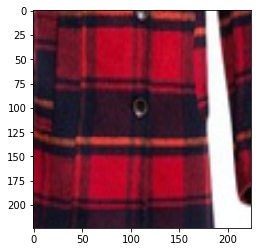

In [29]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


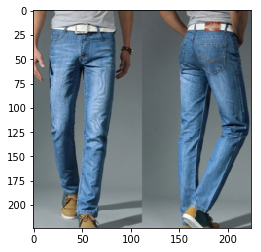

In [30]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

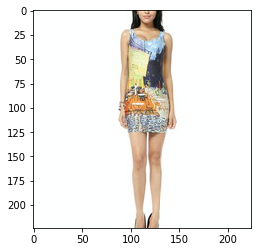

In [31]:
rnd3 = np.random.randint(len(test_dset))
im3 = test_dset[rnd3]
imshow(tensor_to_numpy(im3, args.pretrain_dset_mean, args.pretrain_dset_std))


# DataLoader

In [32]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [33]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )

test_loader = torch.utils.data.DataLoader(test_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )



In [34]:
# train_images, train_labels = next(iter(train_loader))

In [35]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [36]:
# val_images, val_labels = next(iter(val_loader))

In [37]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [38]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [39]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet101'


In [41]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  42967332  trainable parameters


In [42]:
class WeightUpdateTracker:
    
    def __init__(self, model):
        with torch.no_grad():
            self.num_param_tensors = len(list(model.parameters()))
            self.prev_pnorms = torch.zeros(self.num_param_tensors) 
            self.curr_pnorms = self.parameter_norms(model) 

    def parameter_norms(self, model):
        with torch.no_grad():
            pnorms = torch.zeros(self.num_param_tensors)
            for i, x in enumerate(list(model.parameters())):
                pnorms[i] = x.norm().item()
            return pnorms
        
    def track(self, model):
        with torch.no_grad():
            self.prev_pnorms = self.curr_pnorms.clone()
            self.curr_pnorms = self.parameter_norms(model)
            self.delta = (self.curr_pnorms - self.prev_pnorms) / self.prev_pnorms

            
    def __repr__(self):
        with torch.no_grad():
            return self.delta.__repr__()
        

# Loss Function


In [43]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [44]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [45]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [46]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', best_model_filename='model_best.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_model_filename)

In [47]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold).float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [48]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [49]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure, args):
    if not args.test_overfit:
        scheduler.step(measure)


In [50]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        cmpoint5.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {cmpoint5.precision:.3f}\t'
                  'Recall {cmpoint5.recall:.3f}\t'
                  'F1 {cmpoint5.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, cmpoint5=cmpoint5))

In [51]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    cmpoint5 = F1MicroAverageMeter(threshold=0.5)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            cmpoint5.update(target, torch.exp(output))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {cmpoint5.precision:.3f}\t'
                      'Recall {cmpoint5.recall:.3f}\t'
                      'F1 {cmpoint5.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       cmpoint5=cmpoint5))

        print(' * Precision {cmpoint5.precision:.3f} Recall {cmpoint5.recall:.3f} F1 {cmpoint5.f1:.3f}'
              .format(cmpoint5=cmpoint5))

    return cmpoint5.f1

In [52]:
def test(ofname, pfname, args, test_dset, test_loader, best_model_ckpt, model, threshold=0.5, epoch=0):
    
#     checkpoint = torch.load(best_model_ckpt)
#     model.load_state_dict(checkpoint['state_dict'])
    
    batch_time = AverageMeter()
    res = OrderedDict()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, input in enumerate(test_loader):
            # compute output
            output = model(input)
            spout = coo_matrix(torch.exp(output).ge(threshold).int().cpu().numpy())
            for p in zip(spout.row, spout.col):
                imid = test_dset.image_ids[i* args.batch_size+p[0]]
                if imid not in res.keys():
                    res[imid] = [p[1]+1]
                else:
                    res[imid].append(p[1]+1)
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'.format(
                       i, len(test_loader), batch_time=batch_time))
    
    ofname_ = "%s%s%03d_%s" % (os.path.dirname(ofname), os.sep, epoch, os.path.basename(ofname))
    with open(ofname_, "w") as ofd:
        ofd.write("image_id,label_id\n")
        for k, v in res.items():
            ofd.write("%d,%s\n" % (k, " ".join(map(str,v))))
            
    pfname_ = "%s%s%03d_%s" % (os.path.dirname(pfname), os.sep, epoch, os.path.basename(pfname))
    with open(pfname_, "w") as pfd:
        json.dump(vars(args), pfd, sort_keys=True, indent=4)
            
    print("Output written to %s\n" % ofname_)
    print("Program parameters written to %s\n" % pfname_)
    sys.stdout.flush()

In [53]:
def train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, threshold=0.5):
    if args.evaluate:
        validate(val_loader, model, criterion)
    else:
        model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
        wut = None
        if args.debug_weights:
            wut = WeightUpdateTracker(model)
        for epoch in range(args.start_epoch, args.epochs):
            if args.distributed:
                train_sampler.set_epoch(epoch)
    #         adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            train(train_loader, model, criterion, optimizer, epoch)

            if args.debug_weights:
                # debug: track weight updates
                wut.track(model)
                print(wut)

            # evaluate on validation set
            f1 = validate(val_loader, model, criterion)

            # remember best f1 and save checkpoint
            is_best = f1 > best_f1
            best_f1 = max(f1, best_f1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_f1': best_f1,
                'optimizer' : optimizer.state_dict(),
               # 'scheduler' : scheduler.state_dict(),
            }, is_best, filename=args.ckpt, best_model_filename=args.best)

            if is_best:
                print("BEST: ", epoch)
                sys.stdout.flush()
            adjust_learning_rate(optimizer, scheduler, epoch, f1, args)
            test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, threshold=args.threshold, epoch=epoch)            
            


In [54]:
train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, threshold=args.threshold)

Epoch: [0][0/466]	Time 6.131 (6.131)	Data 0.851 (0.851)	Loss 0.4201 (0.4201)	Precision 0.022	Recall 0.453	F1 0.041
Epoch: [0][16/466]	Time 0.351 (0.702)	Data 0.000 (0.050)	Loss 0.1891 (0.2993)	Precision 0.063	Recall 0.269	F1 0.103
Epoch: [0][32/466]	Time 0.343 (0.536)	Data 0.000 (0.026)	Loss 0.0883 (0.2163)	Precision 0.099	Recall 0.226	F1 0.137
Epoch: [0][48/466]	Time 0.371 (0.480)	Data 0.000 (0.018)	Loss 0.0862 (0.1749)	Precision 0.130	Recall 0.212	F1 0.161
Epoch: [0][64/466]	Time 0.370 (0.450)	Data 0.000 (0.013)	Loss 0.0814 (0.1518)	Precision 0.164	Recall 0.215	F1 0.186
Epoch: [0][80/466]	Time 0.370 (0.433)	Data 0.001 (0.011)	Loss 0.0731 (0.1376)	Precision 0.193	Recall 0.217	F1 0.205
Epoch: [0][96/466]	Time 0.352 (0.421)	Data 0.000 (0.009)	Loss 0.0759 (0.1279)	Precision 0.224	Recall 0.225	F1 0.225
Epoch: [0][112/466]	Time 0.351 (0.412)	Data 0.000 (0.008)	Loss 0.0748 (0.1211)	Precision 0.248	Recall 0.230	F1 0.239
Epoch: [0][128/466]	Time 0.375 (0.406)	Data 0.000 (0.007)	Loss 0.0751 (0

Test: [432/2349]	Time 0.099 (0.102)	
Test: [448/2349]	Time 0.099 (0.102)	
Test: [464/2349]	Time 0.100 (0.102)	
Test: [480/2349]	Time 0.099 (0.102)	
Test: [496/2349]	Time 0.099 (0.102)	
Test: [512/2349]	Time 0.100 (0.101)	
Test: [528/2349]	Time 0.099 (0.101)	
Test: [544/2349]	Time 0.100 (0.101)	
Test: [560/2349]	Time 0.100 (0.101)	
Test: [576/2349]	Time 0.099 (0.101)	
Test: [592/2349]	Time 0.099 (0.101)	
Test: [608/2349]	Time 0.100 (0.101)	
Test: [624/2349]	Time 0.099 (0.101)	
Test: [640/2349]	Time 0.100 (0.101)	
Test: [656/2349]	Time 0.099 (0.101)	
Test: [672/2349]	Time 0.099 (0.101)	
Test: [688/2349]	Time 0.098 (0.101)	
Test: [704/2349]	Time 0.099 (0.101)	
Test: [720/2349]	Time 0.099 (0.101)	
Test: [736/2349]	Time 0.099 (0.101)	
Test: [752/2349]	Time 0.099 (0.101)	
Test: [768/2349]	Time 0.102 (0.101)	
Test: [784/2349]	Time 0.100 (0.101)	
Test: [800/2349]	Time 0.099 (0.101)	
Test: [816/2349]	Time 0.099 (0.101)	
Test: [832/2349]	Time 0.099 (0.101)	
Test: [848/2349]	Time 0.100 (0.101)	
T

Epoch: [1][464/466]	Time 0.339 (0.341)	Data 0.000 (0.002)	Loss 0.0820 (0.0698)	Precision 0.610	Recall 0.361	F1 0.454
Test: [0/619]	Time 1.323 (1.323)	Loss 0.0963 (0.0963)	Precision 0.600	Recall 0.361	F1 0.451
Test: [16/619]	Time 0.362 (0.239)	Loss 0.0830 (0.0983)	Precision 0.630	Recall 0.336	F1 0.439
Test: [32/619]	Time 0.306 (0.202)	Loss 0.0900 (0.0959)	Precision 0.641	Recall 0.345	F1 0.448
Test: [48/619]	Time 0.216 (0.192)	Loss 0.0973 (0.0970)	Precision 0.644	Recall 0.345	F1 0.449
Test: [64/619]	Time 0.100 (0.183)	Loss 0.0845 (0.0978)	Precision 0.641	Recall 0.344	F1 0.448
Test: [80/619]	Time 0.156 (0.172)	Loss 0.1007 (0.0980)	Precision 0.644	Recall 0.344	F1 0.449
Test: [96/619]	Time 0.257 (0.167)	Loss 0.0986 (0.0980)	Precision 0.645	Recall 0.345	F1 0.449
Test: [112/619]	Time 0.216 (0.162)	Loss 0.0987 (0.0980)	Precision 0.647	Recall 0.345	F1 0.450
Test: [128/619]	Time 0.122 (0.157)	Loss 0.0939 (0.0975)	Precision 0.646	Recall 0.344	F1 0.449
Test: [144/619]	Time 0.099 (0.154)	Loss 0.093

Test: [1872/2349]	Time 0.100 (0.101)	
Test: [1888/2349]	Time 0.101 (0.101)	
Test: [1904/2349]	Time 0.101 (0.101)	
Test: [1920/2349]	Time 0.101 (0.101)	
Test: [1936/2349]	Time 0.100 (0.101)	
Test: [1952/2349]	Time 0.101 (0.101)	
Test: [1968/2349]	Time 0.101 (0.101)	
Test: [1984/2349]	Time 0.100 (0.101)	
Test: [2000/2349]	Time 0.101 (0.101)	
Test: [2016/2349]	Time 0.102 (0.101)	
Test: [2032/2349]	Time 0.102 (0.101)	
Test: [2048/2349]	Time 0.101 (0.101)	
Test: [2064/2349]	Time 0.101 (0.101)	
Test: [2080/2349]	Time 0.101 (0.101)	
Test: [2096/2349]	Time 0.101 (0.101)	
Test: [2112/2349]	Time 0.101 (0.101)	
Test: [2128/2349]	Time 0.101 (0.101)	
Test: [2144/2349]	Time 0.101 (0.101)	
Test: [2160/2349]	Time 0.101 (0.101)	
Test: [2176/2349]	Time 0.102 (0.101)	
Test: [2192/2349]	Time 0.100 (0.101)	
Test: [2208/2349]	Time 0.101 (0.101)	
Test: [2224/2349]	Time 0.101 (0.101)	
Test: [2240/2349]	Time 0.102 (0.101)	
Test: [2256/2349]	Time 0.100 (0.101)	
Test: [2272/2349]	Time 0.101 (0.101)	
Test: [2288/

Test: [560/619]	Time 0.107 (0.146)	Loss 0.0984 (0.0999)	Precision 0.642	Recall 0.358	F1 0.459
Test: [576/619]	Time 0.111 (0.146)	Loss 0.0993 (0.1000)	Precision 0.642	Recall 0.357	F1 0.459
Test: [592/619]	Time 0.099 (0.146)	Loss 0.1150 (0.1000)	Precision 0.642	Recall 0.357	F1 0.459
Test: [608/619]	Time 0.103 (0.146)	Loss 0.1098 (0.1001)	Precision 0.642	Recall 0.357	F1 0.459
 * Precision 0.642 Recall 0.357 F1 0.459
BEST:  2
Test: [0/2349]	Time 0.972 (0.972)	
Test: [16/2349]	Time 0.101 (0.152)	
Test: [32/2349]	Time 0.103 (0.127)	
Test: [48/2349]	Time 0.101 (0.119)	
Test: [64/2349]	Time 0.099 (0.114)	
Test: [80/2349]	Time 0.101 (0.112)	
Test: [96/2349]	Time 0.101 (0.110)	
Test: [112/2349]	Time 0.101 (0.108)	
Test: [128/2349]	Time 0.101 (0.107)	
Test: [144/2349]	Time 0.101 (0.107)	
Test: [160/2349]	Time 0.103 (0.106)	
Test: [176/2349]	Time 0.101 (0.106)	
Test: [192/2349]	Time 0.101 (0.105)	
Test: [208/2349]	Time 0.099 (0.105)	
Test: [224/2349]	Time 0.101 (0.105)	
Test: [240/2349]	Time 0.103

Epoch: [3][272/466]	Time 0.393 (0.396)	Data 0.000 (0.003)	Loss 0.0650 (0.0654)	Precision 0.621	Recall 0.414	F1 0.497
Epoch: [3][288/466]	Time 0.394 (0.396)	Data 0.000 (0.003)	Loss 0.0674 (0.0654)	Precision 0.620	Recall 0.414	F1 0.496
Epoch: [3][304/466]	Time 0.390 (0.395)	Data 0.000 (0.003)	Loss 0.0559 (0.0654)	Precision 0.620	Recall 0.414	F1 0.497
Epoch: [3][320/466]	Time 0.392 (0.395)	Data 0.000 (0.003)	Loss 0.0710 (0.0654)	Precision 0.619	Recall 0.414	F1 0.496
Epoch: [3][336/466]	Time 0.393 (0.395)	Data 0.000 (0.003)	Loss 0.0796 (0.0655)	Precision 0.619	Recall 0.413	F1 0.496
Epoch: [3][352/466]	Time 0.395 (0.395)	Data 0.000 (0.003)	Loss 0.0615 (0.0655)	Precision 0.618	Recall 0.415	F1 0.496
Epoch: [3][368/466]	Time 0.393 (0.395)	Data 0.001 (0.003)	Loss 0.0603 (0.0654)	Precision 0.616	Recall 0.415	F1 0.496
Epoch: [3][384/466]	Time 0.390 (0.395)	Data 0.000 (0.003)	Loss 0.0578 (0.0654)	Precision 0.616	Recall 0.415	F1 0.496
Epoch: [3][400/466]	Time 0.393 (0.395)	Data 0.001 (0.002)	Loss 0

Test: [1280/2349]	Time 0.101 (0.111)	
Test: [1296/2349]	Time 0.099 (0.111)	
Test: [1312/2349]	Time 0.099 (0.110)	
Test: [1328/2349]	Time 0.099 (0.110)	
Test: [1344/2349]	Time 0.100 (0.110)	
Test: [1360/2349]	Time 0.099 (0.110)	
Test: [1376/2349]	Time 0.100 (0.110)	
Test: [1392/2349]	Time 0.100 (0.110)	
Test: [1408/2349]	Time 0.099 (0.110)	
Test: [1424/2349]	Time 0.098 (0.110)	
Test: [1440/2349]	Time 0.101 (0.110)	
Test: [1456/2349]	Time 0.100 (0.109)	
Test: [1472/2349]	Time 0.100 (0.109)	
Test: [1488/2349]	Time 0.100 (0.109)	
Test: [1504/2349]	Time 0.099 (0.109)	
Test: [1520/2349]	Time 0.100 (0.109)	
Test: [1536/2349]	Time 0.100 (0.109)	
Test: [1552/2349]	Time 0.100 (0.109)	
Test: [1568/2349]	Time 0.100 (0.109)	
Test: [1584/2349]	Time 0.100 (0.109)	
Test: [1600/2349]	Time 0.105 (0.109)	
Test: [1616/2349]	Time 0.100 (0.109)	
Test: [1632/2349]	Time 0.099 (0.108)	
Test: [1648/2349]	Time 0.099 (0.108)	
Test: [1664/2349]	Time 0.100 (0.108)	
Test: [1680/2349]	Time 0.099 (0.108)	
Test: [1696/

Test: [320/619]	Time 0.105 (0.157)	Loss 0.1057 (0.0956)	Precision 0.629	Recall 0.423	F1 0.506
Test: [336/619]	Time 0.100 (0.157)	Loss 0.1000 (0.0960)	Precision 0.629	Recall 0.422	F1 0.505
Test: [352/619]	Time 0.107 (0.157)	Loss 0.1081 (0.0963)	Precision 0.629	Recall 0.420	F1 0.504
Test: [368/619]	Time 0.106 (0.156)	Loss 0.0929 (0.0963)	Precision 0.628	Recall 0.420	F1 0.504
Test: [384/619]	Time 0.104 (0.156)	Loss 0.0912 (0.0963)	Precision 0.629	Recall 0.421	F1 0.505
Test: [400/619]	Time 0.105 (0.156)	Loss 0.1078 (0.0963)	Precision 0.627	Recall 0.420	F1 0.503
Test: [416/619]	Time 0.100 (0.156)	Loss 0.1018 (0.0963)	Precision 0.627	Recall 0.420	F1 0.503
Test: [432/619]	Time 0.104 (0.155)	Loss 0.1001 (0.0963)	Precision 0.627	Recall 0.420	F1 0.503
Test: [448/619]	Time 0.104 (0.155)	Loss 0.1127 (0.0964)	Precision 0.627	Recall 0.420	F1 0.503
Test: [464/619]	Time 0.104 (0.154)	Loss 0.1033 (0.0965)	Precision 0.627	Recall 0.419	F1 0.502
Test: [480/619]	Time 0.100 (0.154)	Loss 0.0920 (0.0965)	Prec

Epoch: [5][80/466]	Time 0.336 (0.349)	Data 0.000 (0.012)	Loss 0.0746 (0.0618)	Precision 0.633	Recall 0.456	F1 0.530
Epoch: [5][96/466]	Time 0.337 (0.347)	Data 0.000 (0.010)	Loss 0.0578 (0.0616)	Precision 0.630	Recall 0.456	F1 0.529
Epoch: [5][112/466]	Time 0.333 (0.346)	Data 0.000 (0.009)	Loss 0.0642 (0.0618)	Precision 0.628	Recall 0.453	F1 0.527
Epoch: [5][128/466]	Time 0.342 (0.344)	Data 0.000 (0.008)	Loss 0.0646 (0.0618)	Precision 0.624	Recall 0.451	F1 0.524
Epoch: [5][144/466]	Time 0.335 (0.343)	Data 0.000 (0.007)	Loss 0.0631 (0.0619)	Precision 0.623	Recall 0.449	F1 0.522
Epoch: [5][160/466]	Time 0.334 (0.342)	Data 0.000 (0.006)	Loss 0.0626 (0.0619)	Precision 0.623	Recall 0.449	F1 0.522
Epoch: [5][176/466]	Time 0.336 (0.342)	Data 0.000 (0.006)	Loss 0.0549 (0.0620)	Precision 0.623	Recall 0.450	F1 0.523
Epoch: [5][192/466]	Time 0.336 (0.341)	Data 0.000 (0.005)	Loss 0.0657 (0.0619)	Precision 0.625	Recall 0.451	F1 0.524
Epoch: [5][208/466]	Time 0.337 (0.341)	Data 0.000 (0.005)	Loss 0.0

Test: [688/2349]	Time 0.100 (0.101)	
Test: [704/2349]	Time 0.100 (0.101)	
Test: [720/2349]	Time 0.100 (0.101)	
Test: [736/2349]	Time 0.100 (0.101)	
Test: [752/2349]	Time 0.099 (0.101)	
Test: [768/2349]	Time 0.100 (0.101)	
Test: [784/2349]	Time 0.098 (0.101)	
Test: [800/2349]	Time 0.099 (0.101)	
Test: [816/2349]	Time 0.099 (0.101)	
Test: [832/2349]	Time 0.100 (0.101)	
Test: [848/2349]	Time 0.100 (0.101)	
Test: [864/2349]	Time 0.099 (0.101)	
Test: [880/2349]	Time 0.100 (0.101)	
Test: [896/2349]	Time 0.100 (0.101)	
Test: [912/2349]	Time 0.101 (0.101)	
Test: [928/2349]	Time 0.099 (0.101)	
Test: [944/2349]	Time 0.100 (0.101)	
Test: [960/2349]	Time 0.100 (0.101)	
Test: [976/2349]	Time 0.099 (0.101)	
Test: [992/2349]	Time 0.098 (0.101)	
Test: [1008/2349]	Time 0.099 (0.101)	
Test: [1024/2349]	Time 0.100 (0.101)	
Test: [1040/2349]	Time 0.099 (0.101)	
Test: [1056/2349]	Time 0.099 (0.101)	
Test: [1072/2349]	Time 0.100 (0.101)	
Test: [1088/2349]	Time 0.100 (0.101)	
Test: [1104/2349]	Time 0.100 (0.

Test: [80/619]	Time 0.346 (0.187)	Loss 0.1015 (0.0978)	Precision 0.618	Recall 0.430	F1 0.507
Test: [96/619]	Time 0.161 (0.177)	Loss 0.0980 (0.0979)	Precision 0.619	Recall 0.430	F1 0.508
Test: [112/619]	Time 0.268 (0.173)	Loss 0.0959 (0.0977)	Precision 0.621	Recall 0.431	F1 0.509
Test: [128/619]	Time 0.228 (0.169)	Loss 0.0990 (0.0972)	Precision 0.619	Recall 0.430	F1 0.507
Test: [144/619]	Time 0.202 (0.166)	Loss 0.0941 (0.0974)	Precision 0.618	Recall 0.429	F1 0.506
Test: [160/619]	Time 0.279 (0.164)	Loss 0.0933 (0.0970)	Precision 0.619	Recall 0.432	F1 0.509
Test: [176/619]	Time 0.406 (0.164)	Loss 0.1044 (0.0968)	Precision 0.620	Recall 0.432	F1 0.509
Test: [192/619]	Time 0.239 (0.162)	Loss 0.0979 (0.0969)	Precision 0.619	Recall 0.432	F1 0.509
Test: [208/619]	Time 0.178 (0.160)	Loss 0.1033 (0.0970)	Precision 0.619	Recall 0.432	F1 0.508
Test: [224/619]	Time 0.198 (0.159)	Loss 0.0955 (0.0968)	Precision 0.619	Recall 0.431	F1 0.508
Test: [240/619]	Time 0.268 (0.158)	Loss 0.1052 (0.0970)	Precis

Test: [2128/2349]	Time 0.117 (0.118)	
Test: [2144/2349]	Time 0.116 (0.118)	
Test: [2160/2349]	Time 0.117 (0.118)	
Test: [2176/2349]	Time 0.117 (0.118)	
Test: [2192/2349]	Time 0.118 (0.118)	
Test: [2208/2349]	Time 0.120 (0.118)	
Test: [2224/2349]	Time 0.115 (0.118)	
Test: [2240/2349]	Time 0.119 (0.118)	
Test: [2256/2349]	Time 0.116 (0.118)	
Test: [2272/2349]	Time 0.117 (0.118)	
Test: [2288/2349]	Time 0.118 (0.118)	
Test: [2304/2349]	Time 0.117 (0.118)	
Test: [2320/2349]	Time 0.120 (0.118)	
Test: [2336/2349]	Time 0.120 (0.118)	
Output written to /data/datasets/kaggle_fashion/data/output/submissions/006_output_deccanlearners_resnet101_sourabhd-desktop_20180528040313170839.csv

Program parameters written to /data/datasets/kaggle_fashion/data/output/submissions/006_params_deccanlearners_resnet101_sourabhd-desktop_20180528040313170839.json

Epoch: [7][0/466]	Time 1.240 (1.240)	Data 0.853 (0.853)	Loss 0.0646 (0.0646)	Precision 0.606	Recall 0.439	F1 0.509
Epoch: [7][16/466]	Time 0.395 (0.444)	

Test: [64/2349]	Time 0.099 (0.125)	
Test: [80/2349]	Time 0.100 (0.120)	
Test: [96/2349]	Time 0.098 (0.117)	
Test: [112/2349]	Time 0.100 (0.114)	
Test: [128/2349]	Time 0.099 (0.112)	
Test: [144/2349]	Time 0.099 (0.111)	
Test: [160/2349]	Time 0.100 (0.110)	
Test: [176/2349]	Time 0.099 (0.109)	
Test: [192/2349]	Time 0.098 (0.108)	
Test: [208/2349]	Time 0.099 (0.107)	
Test: [224/2349]	Time 0.099 (0.107)	
Test: [240/2349]	Time 0.099 (0.106)	
Test: [256/2349]	Time 0.098 (0.106)	
Test: [272/2349]	Time 0.099 (0.106)	
Test: [288/2349]	Time 0.099 (0.105)	
Test: [304/2349]	Time 0.098 (0.105)	
Test: [320/2349]	Time 0.100 (0.105)	
Test: [336/2349]	Time 0.100 (0.104)	
Test: [352/2349]	Time 0.098 (0.104)	
Test: [368/2349]	Time 0.100 (0.104)	
Test: [384/2349]	Time 0.193 (0.104)	
Test: [400/2349]	Time 0.100 (0.104)	
Test: [416/2349]	Time 0.100 (0.104)	
Test: [432/2349]	Time 0.099 (0.104)	
Test: [448/2349]	Time 0.099 (0.104)	
Test: [464/2349]	Time 0.099 (0.103)	
Test: [480/2349]	Time 0.099 (0.103)	
Test

Epoch: [8][352/466]	Time 0.335 (0.346)	Data 0.000 (0.007)	Loss 0.0500 (0.0593)	Precision 0.626	Recall 0.488	F1 0.548
Epoch: [8][368/466]	Time 0.333 (0.345)	Data 0.000 (0.007)	Loss 0.0647 (0.0594)	Precision 0.625	Recall 0.487	F1 0.548
Epoch: [8][384/466]	Time 0.334 (0.345)	Data 0.000 (0.006)	Loss 0.0565 (0.0594)	Precision 0.626	Recall 0.487	F1 0.548
Epoch: [8][400/466]	Time 0.336 (0.344)	Data 0.000 (0.006)	Loss 0.0555 (0.0594)	Precision 0.625	Recall 0.487	F1 0.548
Epoch: [8][416/466]	Time 0.332 (0.344)	Data 0.000 (0.006)	Loss 0.0557 (0.0594)	Precision 0.625	Recall 0.487	F1 0.548
Epoch: [8][432/466]	Time 0.335 (0.344)	Data 0.000 (0.006)	Loss 0.0658 (0.0594)	Precision 0.626	Recall 0.487	F1 0.548
Epoch: [8][448/466]	Time 0.334 (0.343)	Data 0.000 (0.005)	Loss 0.0654 (0.0595)	Precision 0.625	Recall 0.487	F1 0.548
Epoch: [8][464/466]	Time 0.336 (0.343)	Data 0.000 (0.005)	Loss 0.0660 (0.0595)	Precision 0.626	Recall 0.488	F1 0.548
Test: [0/619]	Time 1.571 (1.571)	Loss 0.0852 (0.0852)	Precision 

Test: [1536/2349]	Time 0.100 (0.100)	
Test: [1552/2349]	Time 0.099 (0.100)	
Test: [1568/2349]	Time 0.100 (0.100)	
Test: [1584/2349]	Time 0.100 (0.100)	
Test: [1600/2349]	Time 0.100 (0.100)	
Test: [1616/2349]	Time 0.099 (0.100)	
Test: [1632/2349]	Time 0.098 (0.100)	
Test: [1648/2349]	Time 0.099 (0.100)	
Test: [1664/2349]	Time 0.099 (0.100)	
Test: [1680/2349]	Time 0.100 (0.100)	
Test: [1696/2349]	Time 0.100 (0.100)	
Test: [1712/2349]	Time 0.100 (0.100)	
Test: [1728/2349]	Time 0.100 (0.100)	
Test: [1744/2349]	Time 0.099 (0.100)	
Test: [1760/2349]	Time 0.099 (0.100)	
Test: [1776/2349]	Time 0.099 (0.100)	
Test: [1792/2349]	Time 0.099 (0.100)	
Test: [1808/2349]	Time 0.099 (0.100)	
Test: [1824/2349]	Time 0.099 (0.100)	
Test: [1840/2349]	Time 0.099 (0.100)	
Test: [1856/2349]	Time 0.099 (0.100)	
Test: [1872/2349]	Time 0.100 (0.100)	
Test: [1888/2349]	Time 0.101 (0.100)	
Test: [1904/2349]	Time 0.099 (0.100)	
Test: [1920/2349]	Time 0.099 (0.100)	
Test: [1936/2349]	Time 0.099 (0.100)	
Test: [1952/

Test: [432/619]	Time 0.104 (0.145)	Loss 0.1017 (0.0970)	Precision 0.631	Recall 0.436	F1 0.516
Test: [448/619]	Time 0.100 (0.145)	Loss 0.1134 (0.0971)	Precision 0.631	Recall 0.436	F1 0.515
Test: [464/619]	Time 0.099 (0.145)	Loss 0.1112 (0.0973)	Precision 0.631	Recall 0.435	F1 0.515
Test: [480/619]	Time 0.099 (0.145)	Loss 0.0959 (0.0973)	Precision 0.630	Recall 0.435	F1 0.514
Test: [496/619]	Time 0.108 (0.144)	Loss 0.0833 (0.0972)	Precision 0.630	Recall 0.434	F1 0.514
Test: [512/619]	Time 0.101 (0.144)	Loss 0.0866 (0.0973)	Precision 0.630	Recall 0.434	F1 0.514
Test: [528/619]	Time 0.099 (0.144)	Loss 0.0976 (0.0974)	Precision 0.630	Recall 0.435	F1 0.514
Test: [544/619]	Time 0.098 (0.144)	Loss 0.0995 (0.0974)	Precision 0.630	Recall 0.434	F1 0.514
Test: [560/619]	Time 0.098 (0.144)	Loss 0.0900 (0.0974)	Precision 0.630	Recall 0.435	F1 0.514
Test: [576/619]	Time 0.113 (0.144)	Loss 0.0968 (0.0975)	Precision 0.630	Recall 0.435	F1 0.514
Test: [592/619]	Time 0.107 (0.143)	Loss 0.1068 (0.0975)	Prec

Epoch: [10][176/466]	Time 0.338 (0.343)	Data 0.000 (0.005)	Loss 0.0568 (0.0572)	Precision 0.645	Recall 0.517	F1 0.574
Epoch: [10][192/466]	Time 0.337 (0.342)	Data 0.000 (0.005)	Loss 0.0571 (0.0571)	Precision 0.644	Recall 0.518	F1 0.574
Epoch: [10][208/466]	Time 0.339 (0.342)	Data 0.000 (0.004)	Loss 0.0498 (0.0572)	Precision 0.643	Recall 0.516	F1 0.572
Epoch: [10][224/466]	Time 0.335 (0.342)	Data 0.000 (0.004)	Loss 0.0505 (0.0571)	Precision 0.642	Recall 0.516	F1 0.572
Epoch: [10][240/466]	Time 0.352 (0.342)	Data 0.000 (0.004)	Loss 0.0572 (0.0572)	Precision 0.642	Recall 0.516	F1 0.572
Epoch: [10][256/466]	Time 0.356 (0.342)	Data 0.000 (0.004)	Loss 0.0643 (0.0572)	Precision 0.641	Recall 0.515	F1 0.571
Epoch: [10][272/466]	Time 0.351 (0.343)	Data 0.000 (0.003)	Loss 0.0579 (0.0572)	Precision 0.639	Recall 0.516	F1 0.571
Epoch: [10][288/466]	Time 0.351 (0.343)	Data 0.000 (0.003)	Loss 0.0541 (0.0572)	Precision 0.637	Recall 0.516	F1 0.570
Epoch: [10][304/466]	Time 0.354 (0.344)	Data 0.000 (0.00

Test: [976/2349]	Time 0.103 (0.105)	
Test: [992/2349]	Time 0.103 (0.105)	
Test: [1008/2349]	Time 0.104 (0.105)	
Test: [1024/2349]	Time 0.104 (0.105)	
Test: [1040/2349]	Time 0.105 (0.105)	
Test: [1056/2349]	Time 0.106 (0.105)	
Test: [1072/2349]	Time 0.104 (0.105)	
Test: [1088/2349]	Time 0.104 (0.105)	
Test: [1104/2349]	Time 0.104 (0.105)	
Test: [1120/2349]	Time 0.103 (0.105)	
Test: [1136/2349]	Time 0.112 (0.105)	
Test: [1152/2349]	Time 0.104 (0.105)	
Test: [1168/2349]	Time 0.103 (0.105)	
Test: [1184/2349]	Time 0.104 (0.105)	
Test: [1200/2349]	Time 0.104 (0.105)	
Test: [1216/2349]	Time 0.104 (0.105)	
Test: [1232/2349]	Time 0.104 (0.105)	
Test: [1248/2349]	Time 0.104 (0.105)	
Test: [1264/2349]	Time 0.104 (0.105)	
Test: [1280/2349]	Time 0.104 (0.105)	
Test: [1296/2349]	Time 0.106 (0.105)	
Test: [1312/2349]	Time 0.103 (0.105)	
Test: [1328/2349]	Time 0.103 (0.105)	
Test: [1344/2349]	Time 0.103 (0.105)	
Test: [1360/2349]	Time 0.103 (0.105)	
Test: [1376/2349]	Time 0.104 (0.105)	
Test: [1392/23

Test: [192/619]	Time 0.100 (0.152)	Loss 0.0999 (0.0981)	Precision 0.620	Recall 0.451	F1 0.522
Test: [208/619]	Time 0.106 (0.151)	Loss 0.1044 (0.0981)	Precision 0.620	Recall 0.450	F1 0.521
Test: [224/619]	Time 0.100 (0.149)	Loss 0.0944 (0.0979)	Precision 0.619	Recall 0.449	F1 0.521
Test: [240/619]	Time 0.134 (0.149)	Loss 0.1050 (0.0980)	Precision 0.619	Recall 0.448	F1 0.520
Test: [256/619]	Time 0.131 (0.148)	Loss 0.1298 (0.0981)	Precision 0.619	Recall 0.448	F1 0.520
Test: [272/619]	Time 0.147 (0.147)	Loss 0.1094 (0.0985)	Precision 0.618	Recall 0.446	F1 0.518
Test: [288/619]	Time 0.140 (0.147)	Loss 0.1031 (0.0986)	Precision 0.617	Recall 0.445	F1 0.517
Test: [304/619]	Time 0.123 (0.146)	Loss 0.1216 (0.0989)	Precision 0.618	Recall 0.445	F1 0.517
Test: [320/619]	Time 0.188 (0.146)	Loss 0.1105 (0.0991)	Precision 0.617	Recall 0.444	F1 0.516
Test: [336/619]	Time 0.190 (0.145)	Loss 0.1075 (0.0995)	Precision 0.617	Recall 0.443	F1 0.516
Test: [352/619]	Time 0.099 (0.145)	Loss 0.1127 (0.0999)	Prec

Epoch: [12][0/466]	Time 1.396 (1.396)	Data 1.058 (1.058)	Loss 0.0544 (0.0544)	Precision 0.650	Recall 0.605	F1 0.627
Epoch: [12][16/466]	Time 0.333 (0.398)	Data 0.000 (0.063)	Loss 0.0465 (0.0554)	Precision 0.636	Recall 0.551	F1 0.591
Epoch: [12][32/466]	Time 0.334 (0.368)	Data 0.000 (0.033)	Loss 0.0441 (0.0539)	Precision 0.645	Recall 0.558	F1 0.598
Epoch: [12][48/466]	Time 0.335 (0.357)	Data 0.000 (0.022)	Loss 0.0467 (0.0536)	Precision 0.650	Recall 0.548	F1 0.595
Epoch: [12][64/466]	Time 0.332 (0.352)	Data 0.000 (0.017)	Loss 0.0607 (0.0544)	Precision 0.654	Recall 0.542	F1 0.593
Epoch: [12][80/466]	Time 0.335 (0.348)	Data 0.000 (0.014)	Loss 0.0532 (0.0547)	Precision 0.655	Recall 0.542	F1 0.593
Epoch: [12][96/466]	Time 0.334 (0.346)	Data 0.000 (0.011)	Loss 0.0572 (0.0547)	Precision 0.650	Recall 0.543	F1 0.592
Epoch: [12][112/466]	Time 0.334 (0.344)	Data 0.000 (0.010)	Loss 0.0482 (0.0547)	Precision 0.648	Recall 0.542	F1 0.590
Epoch: [12][128/466]	Time 0.334 (0.343)	Data 0.000 (0.009)	Loss 

Test: [400/2349]	Time 0.100 (0.102)	
Test: [416/2349]	Time 0.100 (0.102)	
Test: [432/2349]	Time 0.099 (0.102)	
Test: [448/2349]	Time 0.100 (0.102)	
Test: [464/2349]	Time 0.099 (0.102)	
Test: [480/2349]	Time 0.099 (0.102)	
Test: [496/2349]	Time 0.099 (0.102)	
Test: [512/2349]	Time 0.100 (0.102)	
Test: [528/2349]	Time 0.099 (0.102)	
Test: [544/2349]	Time 0.099 (0.102)	
Test: [560/2349]	Time 0.100 (0.102)	
Test: [576/2349]	Time 0.099 (0.102)	
Test: [592/2349]	Time 0.099 (0.102)	
Test: [608/2349]	Time 0.099 (0.102)	
Test: [624/2349]	Time 0.098 (0.101)	
Test: [640/2349]	Time 0.100 (0.101)	
Test: [656/2349]	Time 0.099 (0.101)	
Test: [672/2349]	Time 0.099 (0.101)	
Test: [688/2349]	Time 0.099 (0.101)	
Test: [704/2349]	Time 0.099 (0.101)	
Test: [720/2349]	Time 0.100 (0.101)	
Test: [736/2349]	Time 0.098 (0.101)	
Test: [752/2349]	Time 0.099 (0.101)	
Test: [768/2349]	Time 0.099 (0.101)	
Test: [784/2349]	Time 0.099 (0.101)	
Test: [800/2349]	Time 0.100 (0.101)	
Test: [816/2349]	Time 0.100 (0.101)	
T

Epoch: [13][448/466]	Time 0.336 (0.338)	Data 0.000 (0.003)	Loss 0.0456 (0.0524)	Precision 0.668	Recall 0.563	F1 0.611
Epoch: [13][464/466]	Time 0.333 (0.338)	Data 0.000 (0.003)	Loss 0.0591 (0.0525)	Precision 0.668	Recall 0.563	F1 0.611
Test: [0/619]	Time 1.375 (1.375)	Loss 0.0845 (0.0845)	Precision 0.700	Recall 0.579	F1 0.634
Test: [16/619]	Time 0.406 (0.243)	Loss 0.0866 (0.0962)	Precision 0.626	Recall 0.448	F1 0.522
Test: [32/619]	Time 0.299 (0.204)	Loss 0.0869 (0.0943)	Precision 0.627	Recall 0.459	F1 0.530
Test: [48/619]	Time 0.343 (0.200)	Loss 0.0954 (0.0955)	Precision 0.632	Recall 0.456	F1 0.530
Test: [64/619]	Time 0.104 (0.189)	Loss 0.0819 (0.0962)	Precision 0.636	Recall 0.455	F1 0.531
Test: [80/619]	Time 0.138 (0.180)	Loss 0.1041 (0.0965)	Precision 0.641	Recall 0.455	F1 0.532
Test: [96/619]	Time 0.099 (0.174)	Loss 0.0945 (0.0964)	Precision 0.640	Recall 0.453	F1 0.531
Test: [112/619]	Time 0.099 (0.170)	Loss 0.0975 (0.0960)	Precision 0.644	Recall 0.456	F1 0.534
Test: [128/619]	Time

Test: [1824/2349]	Time 0.099 (0.100)	
Test: [1840/2349]	Time 0.098 (0.100)	
Test: [1856/2349]	Time 0.104 (0.100)	
Test: [1872/2349]	Time 0.099 (0.100)	
Test: [1888/2349]	Time 0.099 (0.100)	
Test: [1904/2349]	Time 0.102 (0.100)	
Test: [1920/2349]	Time 0.100 (0.100)	
Test: [1936/2349]	Time 0.099 (0.100)	
Test: [1952/2349]	Time 0.103 (0.100)	
Test: [1968/2349]	Time 0.099 (0.100)	
Test: [1984/2349]	Time 0.099 (0.100)	
Test: [2000/2349]	Time 0.103 (0.100)	
Test: [2016/2349]	Time 0.099 (0.100)	
Test: [2032/2349]	Time 0.102 (0.100)	
Test: [2048/2349]	Time 0.102 (0.100)	
Test: [2064/2349]	Time 0.100 (0.100)	
Test: [2080/2349]	Time 0.099 (0.100)	
Test: [2096/2349]	Time 0.103 (0.100)	
Test: [2112/2349]	Time 0.098 (0.100)	
Test: [2128/2349]	Time 0.099 (0.100)	
Test: [2144/2349]	Time 0.103 (0.100)	
Test: [2160/2349]	Time 0.098 (0.100)	
Test: [2176/2349]	Time 0.099 (0.100)	
Test: [2192/2349]	Time 0.099 (0.100)	
Test: [2208/2349]	Time 0.098 (0.100)	
Test: [2224/2349]	Time 0.104 (0.100)	
Test: [2240/

Test: [528/619]	Time 0.098 (0.143)	Loss 0.0921 (0.0980)	Precision 0.654	Recall 0.437	F1 0.524
Test: [544/619]	Time 0.100 (0.143)	Loss 0.1015 (0.0981)	Precision 0.655	Recall 0.436	F1 0.524
Test: [560/619]	Time 0.102 (0.143)	Loss 0.0950 (0.0981)	Precision 0.654	Recall 0.436	F1 0.523
Test: [576/619]	Time 0.099 (0.143)	Loss 0.1017 (0.0982)	Precision 0.654	Recall 0.436	F1 0.524
Test: [592/619]	Time 0.101 (0.143)	Loss 0.1097 (0.0982)	Precision 0.655	Recall 0.436	F1 0.524
Test: [608/619]	Time 0.105 (0.144)	Loss 0.1082 (0.0983)	Precision 0.656	Recall 0.436	F1 0.524
 * Precision 0.656 Recall 0.436 F1 0.524
Test: [0/2349]	Time 1.168 (1.168)	
Test: [16/2349]	Time 0.099 (0.164)	
Test: [32/2349]	Time 0.098 (0.132)	
Test: [48/2349]	Time 0.106 (0.122)	
Test: [64/2349]	Time 0.098 (0.117)	
Test: [80/2349]	Time 0.099 (0.113)	
Test: [96/2349]	Time 0.103 (0.111)	
Test: [112/2349]	Time 0.098 (0.110)	
Test: [128/2349]	Time 0.099 (0.109)	
Test: [144/2349]	Time 0.103 (0.108)	
Test: [160/2349]	Time 0.099 (0.10

Epoch: [15][240/466]	Time 0.346 (0.352)	Data 0.000 (0.004)	Loss 0.0647 (0.0511)	Precision 0.684	Recall 0.570	F1 0.622
Epoch: [15][256/466]	Time 0.349 (0.352)	Data 0.000 (0.004)	Loss 0.0512 (0.0512)	Precision 0.682	Recall 0.569	F1 0.620
Epoch: [15][272/466]	Time 0.344 (0.351)	Data 0.000 (0.004)	Loss 0.0471 (0.0511)	Precision 0.683	Recall 0.570	F1 0.622
Epoch: [15][288/466]	Time 0.352 (0.351)	Data 0.000 (0.004)	Loss 0.0485 (0.0510)	Precision 0.684	Recall 0.571	F1 0.622
Epoch: [15][304/466]	Time 0.348 (0.351)	Data 0.000 (0.004)	Loss 0.0473 (0.0510)	Precision 0.683	Recall 0.571	F1 0.622
Epoch: [15][320/466]	Time 0.354 (0.351)	Data 0.000 (0.003)	Loss 0.0438 (0.0510)	Precision 0.681	Recall 0.570	F1 0.621
Epoch: [15][336/466]	Time 0.347 (0.351)	Data 0.000 (0.003)	Loss 0.0471 (0.0509)	Precision 0.682	Recall 0.572	F1 0.622
Epoch: [15][352/466]	Time 0.348 (0.351)	Data 0.000 (0.003)	Loss 0.0433 (0.0510)	Precision 0.681	Recall 0.570	F1 0.621
Epoch: [15][368/466]	Time 0.344 (0.351)	Data 0.000 (0.00

Test: [1152/2349]	Time 0.103 (0.105)	
Test: [1168/2349]	Time 0.104 (0.105)	
Test: [1184/2349]	Time 0.106 (0.105)	
Test: [1200/2349]	Time 0.103 (0.104)	
Test: [1216/2349]	Time 0.103 (0.104)	
Test: [1232/2349]	Time 0.103 (0.104)	
Test: [1248/2349]	Time 0.103 (0.104)	
Test: [1264/2349]	Time 0.102 (0.104)	
Test: [1280/2349]	Time 0.103 (0.104)	
Test: [1296/2349]	Time 0.103 (0.104)	
Test: [1312/2349]	Time 0.104 (0.104)	
Test: [1328/2349]	Time 0.103 (0.104)	
Test: [1344/2349]	Time 0.103 (0.104)	
Test: [1360/2349]	Time 0.103 (0.104)	
Test: [1376/2349]	Time 0.103 (0.104)	
Test: [1392/2349]	Time 0.103 (0.104)	
Test: [1408/2349]	Time 0.109 (0.104)	
Test: [1424/2349]	Time 0.103 (0.104)	
Test: [1440/2349]	Time 0.102 (0.104)	
Test: [1456/2349]	Time 0.103 (0.104)	
Test: [1472/2349]	Time 0.102 (0.104)	
Test: [1488/2349]	Time 0.104 (0.104)	
Test: [1504/2349]	Time 0.107 (0.104)	
Test: [1520/2349]	Time 0.103 (0.104)	
Test: [1536/2349]	Time 0.103 (0.104)	
Test: [1552/2349]	Time 0.103 (0.104)	
Test: [1568/

Test: [256/619]	Time 0.098 (0.144)	Loss 0.1298 (0.0964)	Precision 0.659	Recall 0.443	F1 0.530
Test: [272/619]	Time 0.098 (0.144)	Loss 0.1067 (0.0967)	Precision 0.658	Recall 0.441	F1 0.528
Test: [288/619]	Time 0.099 (0.144)	Loss 0.1040 (0.0969)	Precision 0.657	Recall 0.440	F1 0.527
Test: [304/619]	Time 0.105 (0.144)	Loss 0.1229 (0.0972)	Precision 0.658	Recall 0.440	F1 0.527
Test: [320/619]	Time 0.109 (0.144)	Loss 0.1082 (0.0974)	Precision 0.658	Recall 0.439	F1 0.526
Test: [336/619]	Time 0.098 (0.143)	Loss 0.1006 (0.0978)	Precision 0.658	Recall 0.437	F1 0.525
Test: [352/619]	Time 0.107 (0.143)	Loss 0.1093 (0.0981)	Precision 0.657	Recall 0.436	F1 0.525
Test: [368/619]	Time 0.187 (0.143)	Loss 0.0909 (0.0980)	Precision 0.657	Recall 0.437	F1 0.525
Test: [384/619]	Time 0.231 (0.143)	Loss 0.0942 (0.0980)	Precision 0.658	Recall 0.437	F1 0.525
Test: [400/619]	Time 0.271 (0.142)	Loss 0.1054 (0.0980)	Precision 0.657	Recall 0.436	F1 0.524
Test: [416/619]	Time 0.264 (0.142)	Loss 0.0989 (0.0980)	Prec

Epoch: [17][32/466]	Time 0.338 (0.369)	Data 0.000 (0.035)	Loss 0.0506 (0.0495)	Precision 0.683	Recall 0.578	F1 0.626
Epoch: [17][48/466]	Time 0.333 (0.358)	Data 0.000 (0.024)	Loss 0.0454 (0.0498)	Precision 0.686	Recall 0.572	F1 0.624
Epoch: [17][64/466]	Time 0.334 (0.352)	Data 0.000 (0.018)	Loss 0.0536 (0.0500)	Precision 0.685	Recall 0.572	F1 0.623
Epoch: [17][80/466]	Time 0.334 (0.348)	Data 0.000 (0.015)	Loss 0.0389 (0.0500)	Precision 0.685	Recall 0.575	F1 0.625
Epoch: [17][96/466]	Time 0.334 (0.346)	Data 0.000 (0.012)	Loss 0.0585 (0.0500)	Precision 0.686	Recall 0.575	F1 0.626
Epoch: [17][112/466]	Time 0.335 (0.345)	Data 0.000 (0.011)	Loss 0.0539 (0.0499)	Precision 0.686	Recall 0.578	F1 0.627
Epoch: [17][128/466]	Time 0.333 (0.343)	Data 0.000 (0.009)	Loss 0.0626 (0.0501)	Precision 0.688	Recall 0.578	F1 0.628
Epoch: [17][144/466]	Time 0.343 (0.343)	Data 0.000 (0.008)	Loss 0.0536 (0.0499)	Precision 0.687	Recall 0.579	F1 0.628
Epoch: [17][160/466]	Time 0.332 (0.342)	Data 0.000 (0.008)	Lo

Test: [496/2349]	Time 0.100 (0.103)	
Test: [512/2349]	Time 0.100 (0.103)	
Test: [528/2349]	Time 0.100 (0.103)	
Test: [544/2349]	Time 0.101 (0.103)	
Test: [560/2349]	Time 0.101 (0.103)	
Test: [576/2349]	Time 0.104 (0.103)	
Test: [592/2349]	Time 0.099 (0.103)	
Test: [608/2349]	Time 0.100 (0.103)	
Test: [624/2349]	Time 0.100 (0.103)	
Test: [640/2349]	Time 0.100 (0.103)	
Test: [656/2349]	Time 0.100 (0.103)	
Test: [672/2349]	Time 0.099 (0.103)	
Test: [688/2349]	Time 0.099 (0.103)	
Test: [704/2349]	Time 0.100 (0.103)	
Test: [720/2349]	Time 0.100 (0.102)	
Test: [736/2349]	Time 0.100 (0.102)	
Test: [752/2349]	Time 0.100 (0.102)	
Test: [768/2349]	Time 0.100 (0.102)	
Test: [784/2349]	Time 0.100 (0.102)	
Test: [800/2349]	Time 0.102 (0.102)	
Test: [816/2349]	Time 0.100 (0.102)	
Test: [832/2349]	Time 0.099 (0.102)	
Test: [848/2349]	Time 0.100 (0.102)	
Test: [864/2349]	Time 0.100 (0.102)	
Test: [880/2349]	Time 0.099 (0.102)	
Test: [896/2349]	Time 0.100 (0.102)	
Test: [912/2349]	Time 0.101 (0.102)	
T

Test: [0/619]	Time 1.744 (1.744)	Loss 0.0861 (0.0861)	Precision 0.712	Recall 0.556	F1 0.624
Test: [16/619]	Time 0.351 (0.275)	Loss 0.0884 (0.0983)	Precision 0.652	Recall 0.435	F1 0.522
Test: [32/619]	Time 0.418 (0.228)	Loss 0.0895 (0.0966)	Precision 0.645	Recall 0.449	F1 0.529
Test: [48/619]	Time 0.363 (0.209)	Loss 0.0973 (0.0977)	Precision 0.650	Recall 0.444	F1 0.528
Test: [64/619]	Time 0.244 (0.197)	Loss 0.0826 (0.0983)	Precision 0.652	Recall 0.443	F1 0.528
Test: [80/619]	Time 0.241 (0.185)	Loss 0.1082 (0.0987)	Precision 0.656	Recall 0.442	F1 0.528
Test: [96/619]	Time 0.181 (0.175)	Loss 0.0970 (0.0986)	Precision 0.655	Recall 0.441	F1 0.527
Test: [112/619]	Time 0.181 (0.168)	Loss 0.0992 (0.0982)	Precision 0.660	Recall 0.444	F1 0.531
Test: [128/619]	Time 0.173 (0.163)	Loss 0.0985 (0.0978)	Precision 0.659	Recall 0.442	F1 0.529
Test: [144/619]	Time 0.100 (0.160)	Loss 0.0933 (0.0979)	Precision 0.658	Recall 0.441	F1 0.528
Test: [160/619]	Time 0.105 (0.157)	Loss 0.0905 (0.0976)	Precision 0.

Test: [1936/2349]	Time 0.100 (0.103)	
Test: [1952/2349]	Time 0.102 (0.103)	
Test: [1968/2349]	Time 0.100 (0.103)	
Test: [1984/2349]	Time 0.099 (0.103)	
Test: [2000/2349]	Time 0.100 (0.103)	
Test: [2016/2349]	Time 0.100 (0.103)	
Test: [2032/2349]	Time 0.099 (0.103)	
Test: [2048/2349]	Time 0.100 (0.103)	
Test: [2064/2349]	Time 0.100 (0.103)	
Test: [2080/2349]	Time 0.100 (0.103)	
Test: [2096/2349]	Time 0.100 (0.103)	
Test: [2112/2349]	Time 0.099 (0.103)	
Test: [2128/2349]	Time 0.100 (0.103)	
Test: [2144/2349]	Time 0.100 (0.103)	
Test: [2160/2349]	Time 0.102 (0.103)	
Test: [2176/2349]	Time 0.101 (0.103)	
Test: [2192/2349]	Time 0.100 (0.103)	
Test: [2208/2349]	Time 0.100 (0.103)	
Test: [2224/2349]	Time 0.101 (0.103)	
Test: [2240/2349]	Time 0.100 (0.103)	
Test: [2256/2349]	Time 0.099 (0.103)	
Test: [2272/2349]	Time 0.101 (0.103)	
Test: [2288/2349]	Time 0.099 (0.103)	
Test: [2304/2349]	Time 0.101 (0.103)	
Test: [2320/2349]	Time 0.100 (0.102)	
Test: [2336/2349]	Time 0.100 (0.102)	
Output writt

Test: [576/619]	Time 0.099 (0.143)	Loss 0.1018 (0.0990)	Precision 0.651	Recall 0.436	F1 0.522
Test: [592/619]	Time 0.099 (0.143)	Loss 0.1084 (0.0990)	Precision 0.652	Recall 0.436	F1 0.522
Test: [608/619]	Time 0.098 (0.143)	Loss 0.1084 (0.0991)	Precision 0.653	Recall 0.436	F1 0.523
 * Precision 0.653 Recall 0.436 F1 0.523
Epoch    19: reducing learning rate of group 0 to 1.0000e-08.
Test: [0/2349]	Time 1.046 (1.046)	
Test: [16/2349]	Time 0.098 (0.159)	
Test: [32/2349]	Time 0.098 (0.130)	
Test: [48/2349]	Time 0.099 (0.120)	
Test: [64/2349]	Time 0.099 (0.115)	
Test: [80/2349]	Time 0.099 (0.112)	
Test: [96/2349]	Time 0.099 (0.110)	
Test: [112/2349]	Time 0.099 (0.108)	
Test: [128/2349]	Time 0.099 (0.107)	
Test: [144/2349]	Time 0.100 (0.106)	
Test: [160/2349]	Time 0.100 (0.106)	
Test: [176/2349]	Time 0.100 (0.105)	
Test: [192/2349]	Time 0.100 (0.105)	
Test: [208/2349]	Time 0.100 (0.104)	
Test: [224/2349]	Time 0.100 (0.104)	
Test: [240/2349]	Time 0.100 (0.104)	
Test: [256/2349]	Time 0.101 (0.

# Inference

In [55]:
# Move inference inside training loop for results from partially trained model
#test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, threshold=args.threshold)

# Save Results